In [15]:
! scp ghpcc:/nl/umw_job_dekker/users/av90w/ChIPseq/fastq/ChIP3/results/bwa/mergedLibrary/NT-CTCF_R1.mLb.clN.sorted.bam.bai ./
! scp ghpcc:/nl/umw_job_dekker/users/av90w/ChIPseq/fastq/ChIP3/results/bwa/mergedLibrary/NT-input_R1.mLb.clN.sorted.bam.bai ./

NT-CTCF_R1.mLb.clN.sorted.bam.bai             100% 2253KB   5.2MB/s   00:00    
NT-input_R1.mLb.clN.sorted.bam.bai            100% 2319KB   3.8MB/s   00:00    


In [21]:
! bamCompare -p 4 --scaleFactorsMethod SES -b1 NT-CTCF_R1.mLb.clN.sorted.bam -b2 NT-input_R1.mLb.clN.sorted.bam -o log2CTCF_input_SES.bw

bamFilesList: ['NT-CTCF_R1.mLb.clN.sorted.bam', 'NT-input_R1.mLb.clN.sorted.bam']
binLength: 50
numberOfSamples: 0
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: read length
numberOfProcessors: 4
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 1000


In [85]:
# Pol II cpomparable to WT - to be downloaded
! scp ghpcc:/nl/umw_job_dekker/users/av90w/cooler/downsampling/PTB2539-NT-pool-800000000.mcool ./
! scp ghpcc:/nl/umw_job_dekker/users/av90w/cooler/downsampling/PTB2539-IAA-pool-800000000.mcool ./

PTB2539-NT-pool-800000000.mcool               100% 4824MB   3.6MB/s   22:15    
PTB2539-IAA-pool-800000000.mcool              100% 4851MB 891.3KB/s 1:32:53    


In [86]:
# Pool HAP1 WT, NO TIR1 and TIR1
! scp ghpcc:/nl/umw_job_dekker/users/av90w/cooler/20210408_merge_NO_TIR1_44/CkoC44-NO-TIR1-pool.mcool ./
! scp ghpcc:/nl/umw_job_dekker/users/av90w/cooler/downsampling/Hap1-WT-combined-500000000.mcool ./
! scp ghpcc:/nl/umw_job_dekker/users/av90w/cooler/downsampling/CkoCT442-NT-pool-500000000.mcool ./
! scp ghpcc:/nl/umw_job_dekker/users/av90w/cooler/downsampling/CkoCT442-IAA-pool-500000000.mcool ./


CkoC44-NO-TIR1-pool.mcool                     100% 3059MB   3.7MB/s   13:54    
Hap1-WT-combined-500000000.mcool              100% 3335MB   3.7MB/s   15:01    
CkoCT442-NT-pool-500000000.mcool              100% 3212MB   4.3MB/s   12:35    
CkoCT442-IAA-pool-500000000.mcool             100% 3160MB   3.6MB/s   14:47    


In [19]:
ls -lah log2CTCF_input.bw

-rw-rw-r-- 1 sergpolly sergpolly 279M Mar 24 20:52 log2CTCF_input.bw


In [9]:
# ! ssh ghpcc ls -lah /nl/umw_job_dekker/users/av90w/ChIPseq/fastq/ChIP3/results/bwa/mergedLibrary

In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
    
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [3]:
# load related modules and such
%load_ext autoreload
%autoreload 2
import os
import cooler
import cooltools
import numpy as np
import pandas as pd
from cooltools import eigdecomp
import bioframe

from cooltools import numutils
from scipy.linalg import block_diag

import multiprocess as mp
from collections import OrderedDict
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import datashader as ds
from datashader.mpl_ext import dsshow, alpha_colormap

In [4]:
binsize = 10_000
binsize_human = f"{int(binsize/1_000)}kb"
diamond = 100_000
diamond_human = f"{int(diamond/1_000)}kb"

ins_samples = OrderedDict()
ins_samples["wt"] = f"Hap1-WT-combined.hg19.{binsize_human}.{diamond_human}.tsv"
ins_samples["polII"] = f"PolII-NT.hg19.{binsize_human}.{diamond_human}.tsv"
ins_samples["nopolII"] = f"PolII-IAA.hg19.{binsize_human}.{diamond_human}.tsv"
ins_samples["ctcf"] = f"all_CTCF_combined.hg19.{binsize_human}.{diamond_human}.tsv"
ins_samples["noctcf"] = f"noCTCF_IAA_combined.hg19.{binsize_human}.{diamond_human}.tsv"

# ins_samples["ctcf"] = f"all_CTCF_combined.hg19.{binsize_human}.{diamond_human}.tsv"
# ins_samples["noctcf"] = f"noCTCF_IAA_combined.hg19.{binsize_human}.{diamond_human}.tsv"

# CkoCT442-NT-pool.mcool
# CkoCT442-IAA-pool.mcool

ins_samples["ctcfG1"] = f"G1-NT.hg19.{binsize_human}.{diamond_human}.tsv"
ins_samples["noctcfG1"] = f"G1-IAA.hg19.{binsize_human}.{diamond_human}.tsv"
ins_samples["noctcf_sh"] = f"CkoC442-IAA48H-R1-T1.hg19.{binsize_human}.{diamond_human}.tsv"
ins_samples["ctcf_sh"] = f"CkoC442-NT-R1-T1.hg19.{binsize_human}.{diamond_human}.tsv"
ins_samples["aavs1-nt"] = f"CkoCT442-AAVS1sg2-4-NT-R1-T1.hg19.{binsize_human}.{diamond_human}.tsv"
ins_samples["ddx55_nt"] = f"CkoCT442-DDX55sg2-B-NT-R1-T1.hg19.{binsize_human}.{diamond_human}.tsv"


In [5]:
# load all pre-calculated insulation for all of the samples
df = OrderedDict()
for k, tsv in ins_samples.items():
    df[k] = pd.read_csv(tsv, sep="\t")


### try to use https://github.com/open2c/open2c_examples/blob/master/Insulation_and_boundaries.ipynb on our boundaries

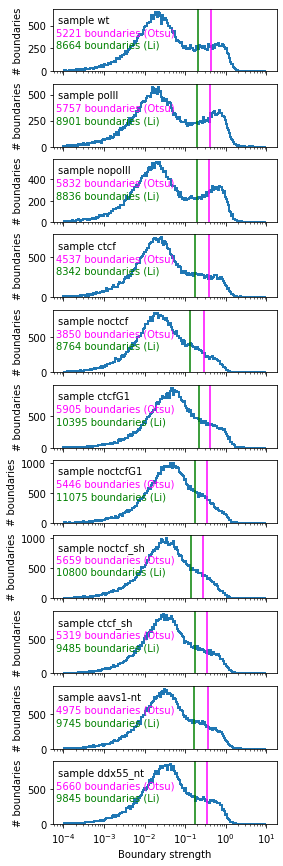

In [6]:
from skimage.filters import threshold_li, threshold_otsu
boundary_strength_key = f"boundary_strength_{diamond}"

histkwargs = dict(
    bins=10**np.linspace(-4,1,200),
    histtype='step',
    lw=2,
)
thresholds_li = {}
thresholds_otsu = {}
f, axs = plt.subplots(len(df),1, sharex=True, figsize=(4,15))
for i, (k, ax) in enumerate(zip(df, axs)):
    ax.hist(
        df[k][boundary_strength_key],
        **histkwargs
    )
    thresholds_li[k] = threshold_li(df[k][boundary_strength_key].dropna().values)
    thresholds_otsu[k] = threshold_otsu(df[k][boundary_strength_key].dropna().values)
    n_boundaries_li = (df[k][boundary_strength_key].dropna()>=thresholds_li[k]).sum()
    n_boundaries_otsu = (df[k][boundary_strength_key].dropna()>=thresholds_otsu[k]).sum()
    ax.axvline(thresholds_li[k], c='green')
    ax.axvline(thresholds_otsu[k], c='magenta')
    ax.text(0.02, 0.9,
             f'sample {k}', 
             ha='left',
             va='top',
             transform=ax.transAxes)
    ax.text(0.01, 0.7,
            f'{n_boundaries_otsu} boundaries (Otsu)',
            c='magenta',
            ha='left',
            va='top',
            transform=ax.transAxes)  
    ax.text(0.01, 0.5,
            f'{n_boundaries_li} boundaries (Li)',
            c='green',
            ha='left',
            va='top',
            transform=ax.transAxes)
    ax.set(
        xscale='log',
        ylabel='# boundaries'
    )
    
axs[-1].set(xlabel='Boundary strength');

### below we'll be trying to extract relevant/strong boundaries and their combinations
### for subsequent stackups ...

In [5]:
# it's nice sometimes to exclude sex chromosomes and mito for analysis
autosomal_chroms = ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9',
 'chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17',
 'chr18','chr19','chr20','chr21','chr22']

In [8]:
bounds = {}
common_threshold = thresholds_otsu["ctcfG1"]
for k in df:
    _bounds_df = df[k].dropna(axis=0, how="any")
    bounds[k] = _bounds_df[
        _bounds_df[boundary_strength_key] >= common_threshold
    ][ ["chrom","start","end"] ]
    # autosomal_chroms only
    autosomal_idx = bounds[k]["chrom"].isin(autosomal_chroms)
    bounds[k] = bounds[k][autosomal_idx].reset_index(drop=True)


In [9]:
# bounds["ctcfG1"].to_csv("ctcfG1_bounds_0.41.10kb.100kb.bed",sep="\t",header=None,index=False)
# bounds["noctcfG1"].to_csv("noctcfG1_bounds_0.41.10kb.100kb.bed",sep="\t",header=None,index=False)
# merged_bounds.to_csv("merged_bounds.bed",sep="\t",header=None,index=False)

In [10]:
subset_samples = [k for k in df][0:3]
subset_samples = ["ctcfG1","noctcfG1"]
print(f"merging following samples {subset_samples} ...")
expected_boundaries = 0
for k in subset_samples:
    print(f"individually {len(bounds[k])}")
    expected_boundaries += len(bounds[k])
merged_bounds = bioframe.merge(
    pd.concat([ bounds[k] for k in subset_samples ]).reset_index(drop=True),
    min_dist=100
)[["chrom","start","end"]]
print(f"merged {len(merged_bounds)}")
print(f"expected number would be {expected_boundaries}")

merging following samples ['ctcfG1', 'noctcfG1'] ...
individually 5610
individually 3891
merged 8084
expected number would be 9501


In [69]:

!ls NT-CTCF-narrowPeaks-sort-merge-with-strength.bed
!ls IAA-CTCF-narrowPeaks-sort-merge-with-strength.bed
!ls NT-DDX55-narrowPeaks-sort-merge-with-strength.bed
!ls IAA-DDX55-narrowPeaks-sort-merge-with-strength.bed
!ls NT-RAD21-narrowPeaks-sort-merge-with-strength.bed
!ls IAA-RAD21-narrowPeaks-sort-merge-with-strength.bed


ls: cannot access 'NT-CTCF-narrowPeaks-sort-merge-with-strength.bed': No such file or directory
ls: cannot access 'IAA-CTCF-narrowPeaks-sort-merge-with-strength.bed': No such file or directory
ls: cannot access 'NT-DDX55-narrowPeaks-sort-merge-with-strength.bed': No such file or directory
ls: cannot access 'IAA-DDX55-narrowPeaks-sort-merge-with-strength.bed': No such file or directory
ls: cannot access 'NT-RAD21-narrowPeaks-sort-merge-with-strength.bed': No such file or directory
ls: cannot access 'IAA-RAD21-narrowPeaks-sort-merge-with-strength.bed': No such file or directory


In [70]:
! ssh ghpcc head /nl/umw_job_dekker/users/av90w/ChIPseq/ChIP4/MACS2/narrow0.01/NT-CTCF-narrowPeaks-sort-merge-with-strength.bed


chr1	10151	10508	81
chr1	237582	237908	404
chr1	714001	714579	283
chr1	804937	805691	7769
chr1	839840	840454	10583
chr1	860116	860589	48
chr1	873599	873857	35
chr1	875596	875897	273
chr1	886876	887183	212
chr1	911495	911765	139


In [71]:
! scp ghpcc:/nl/umw_job_dekker/users/av90w/ChIPseq/ChIP4/MACS2/narrow0.01/NT-CTCF-narrowPeaks-sort-merge-with-strength.bed ./
! scp ghpcc:/nl/umw_job_dekker/users/av90w/ChIPseq/ChIP4/MACS2/narrow0.01/IAA-CTCF-narrowPeaks-sort-merge-with-strength.bed ./
! scp ghpcc:/nl/umw_job_dekker/users/av90w/ChIPseq/ChIP4/MACS2/narrow0.01/NT-DDX55-narrowPeaks-sort-merge-with-strength.bed ./
! scp ghpcc:/nl/umw_job_dekker/users/av90w/ChIPseq/ChIP4/MACS2/narrow0.01/IAA-DDX55-narrowPeaks-sort-merge-with-strength.bed ./
! scp ghpcc:/nl/umw_job_dekker/users/av90w/ChIPseq/ChIP4/MACS2/narrow0.01/NT-RAD21-narrowPeaks-sort-merge-with-strength.bed ./
! scp ghpcc:/nl/umw_job_dekker/users/av90w/ChIPseq/ChIP4/MACS2/narrow0.01/IAA-RAD21-narrowPeaks-sort-merge-with-strength.bed ./

NT-CTCF-narrowPeaks-sort-merge-with-strength. 100%  823KB   2.7MB/s   00:00    
IAA-CTCF-narrowPeaks-sort-merge-with-strength 100%  309KB   1.9MB/s   00:00    
NT-DDX55-narrowPeaks-sort-merge-with-strength 100%   82KB 893.9KB/s   00:00    
IAA-DDX55-narrowPeaks-sort-merge-with-strengt 100%   38KB 514.4KB/s   00:00    
NT-RAD21-narrowPeaks-sort-merge-with-strength 100%  614KB   3.3MB/s   00:00    
IAA-RAD21-narrowPeaks-sort-merge-with-strengt 100%  182KB   1.5MB/s   00:00    


In [115]:
# # merged_bounds
# merged_bounds.to_csv("merged_bounds.bed",sep="\t",header=None,index=False)

In [49]:
# bioframe is short for bioframe here ...
ctcf_df = bioframe.read_table(
    "NT-CTCF-narrowPeaks-sort-merge",
    names=["chrom","start","end"]
)
ctcf_df = ctcf_df.sort_values(["chrom","start"])
ctcf_df = ctcf_df[ ctcf_df["chrom"].isin(autosomal_chroms) ]
ctcf_df = ctcf_df.reset_index(drop=True)

In [50]:
rad21_df = bioframe.read_table(
    "NT-RAD21-narrowPeaks-sort-merge",
    names=["chrom","start","end"]
)
rad21_df = rad21_df.sort_values(["chrom","start"])
rad21_df = rad21_df[ rad21_df["chrom"].isin(autosomal_chroms) ]
rad21_df = rad21_df.reset_index(drop=True)

In [51]:
rad21_IAA_df = bioframe.read_table(
    "IAA-RAD21-narrowPeaks-sort-merge",
    names=["chrom","start","end"]
)
rad21_IAA_df = rad21_IAA_df.sort_values(["chrom","start"])
rad21_IAA_df = rad21_IAA_df[ rad21_IAA_df["chrom"].isin(autosomal_chroms) ]
rad21_IAA_df = rad21_IAA_df.reset_index(drop=True)

In [52]:
# bf is short for bioframe here ...
_df = pd.concat([ctcf_df,rad21_df,rad21_IAA_df]).sort_values(["chrom","start"]).reset_index(drop=True)
bioframe.merge(_df, min_dist=100).to_csv("union_RAD21_CTCF.bed",header=None,index=False,sep="\t")

In [54]:

!wc -l union_RAD21_CTCF.bed

39233 union_RAD21_CTCF.bed


In [29]:
bioframe.overlap(rad21_df,rad21_IAA_df).dropna().reset_index(drop=True).to_csv("rad21_both.bed",header=None,index=False,sep="\t")

In [24]:
bioframe.setdiff(rad21_IAA_df,rad21_df).reset_index(drop=True).to_csv("rad21_onlyIAA.bed",header=None,index=False,sep="\t")
bioframe.setdiff(rad21_df,rad21_IAA_df).reset_index(drop=True).to_csv("rad21_onlyNT.bed",header=None,index=False,sep="\t")

In [30]:
display(ctcf_df.head())
print(len(ctcf_df))
display(rad21_df.head())
print(len(rad21_df))
display(rad21_IAA_df.head())
print(len(rad21_IAA_df))

,chrom,start,end
0,chr1,10151,10508
1,chr1,237582,237908
2,chr1,714001,714579
3,chr1,804937,805691
4,chr1,839840,840454


27891


,chrom,start,end
0,chr1,10125,10442
1,chr1,805137,805533
2,chr1,839834,840961
3,chr1,875607,875826
4,chr1,877161,877453


21648


,chrom,start,end
0,chr1,10124,10456
1,chr1,839984,840274
2,chr1,877014,877363
3,chr1,895846,896519
4,chr1,935691,936267


6589


In [130]:
print(f"merging RAD21-s IAA and NT ...")
expected_boundaries = 0
for _df in [rad21_df, rad21_IAA_df]:
    print(f"individually {len(_df)}")
    expected_boundaries += len(_df)
rad21_merged = bioframe.merge(
    pd.concat([rad21_df, rad21_IAA_df]).reset_index(drop=True),
    min_dist=100
)[["chrom","start","end"]]
print(f"merged {len(rad21_merged)}")
print(f"expected number would be {expected_boundaries}")

merging RAD21-s IAA and NT ...
individually 21648
individually 6589
merged 23279
expected number would be 28237


In [131]:
# # merged_bounds
rad21_merged.to_csv("rad21_merged.bed",sep="\t",header=None,index=False)

### given a list of "roughly" defined boundaries - we want to replace them with the higher precision CTCF-peaks - whenever we can

we'll keep those that do not overlap/intersect with CTCF - because they are the candidates to be the "CTCF-independent" boundaries ...

In [122]:
df1 = bioframe.overlap(merged_bounds, ctcf_df).groupby(["chrom_1","start_1","end_1"]).first()

In [123]:
_df1 = df1[df1["chrom_2"].isnull()].reset_index()[["chrom_1","start_1","end_1"]].rename({"chrom_1":"chrom","start_1":"start","end_1":"end"},axis="columns")
_df2 = df1.dropna().reset_index(drop=True).rename({"chrom_2":"chrom","start_2":"start","end_2":"end"},axis="columns")
print(len(_df1))
print(len(_df2))
# pd.concat([_df1,_df2]).to_csv("merged_bounds.bed",sep="\t",header=None,index=False)

27371
3467


In [34]:
bounds["ctcf"]

,chrom,start,end
0,chr1,836000,838000
1,chr1,934000,936000
2,chr1,1052000,1054000
3,chr1,1126000,1128000
4,chr1,1166000,1168000
...,...,...,...
31615,chr22,50776000,50778000
31616,chr22,50944000,50946000
31617,chr22,50966000,50968000
31618,chr22,51022000,51024000


In [35]:
bounds["wt"]

,chrom,start,end
0,chr1,828000,830000
1,chr1,932000,934000
2,chr1,1052000,1054000
3,chr1,1166000,1168000
4,chr1,1208000,1210000
...,...,...,...
32988,chr22,50944000,50946000
32989,chr22,50966000,50968000
32990,chr22,51020000,51022000
32991,chr22,51078000,51080000


In [23]:
ddf = pd.DataFrame({
    "X":df["wt"]["log2_insulation_score_20000"].values,
    "Y":df["ctcf"]["log2_insulation_score_20000"].values,
    "Z":df["ctcf_sh"]["log2_insulation_score_20000"].values,
    "A":df["noctcf"]["log2_insulation_score_20000"].values,
    "B":df["noctcf_sh"]["log2_insulation_score_20000"].values,
#     "C":df["polII"]["log2_insulation_score_20000"].values,
#     "D":df["nopolII"]["log2_insulation_score_20000"].values,
})


In [24]:
sss = ["X","Y","Z","A","B"]#,"C","D"]

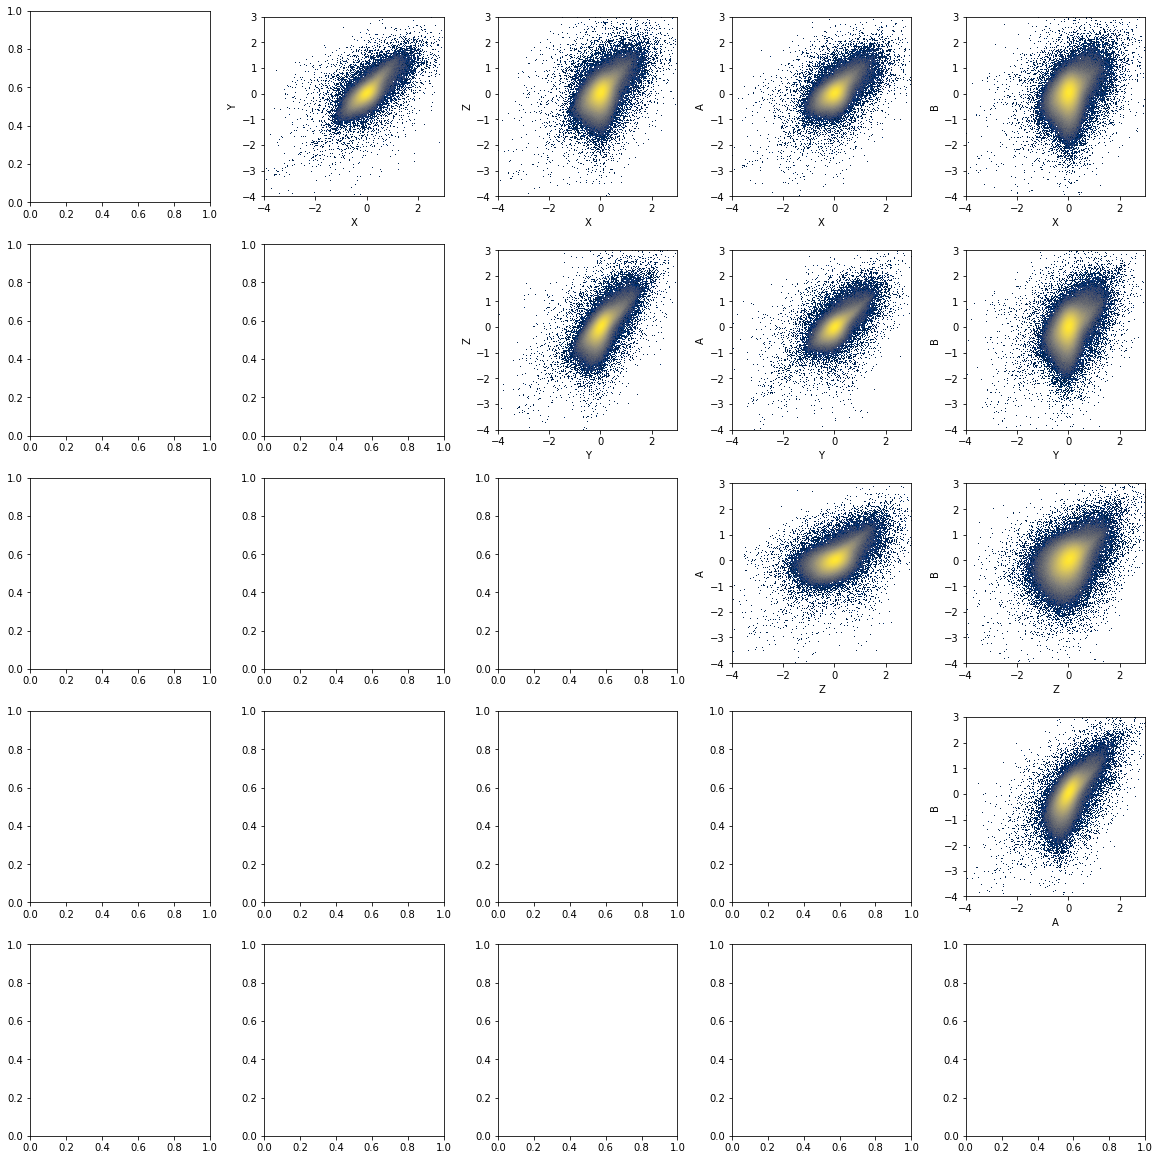

In [25]:
fig = plt.figure(figsize=(16,16),constrained_layout=True)
gs = fig.add_gridspec(len(sss),len(sss))

axs = [[] for _ in sss]
np.empty((len(sss),len(sss)))
for i in range(len(sss)):
    for j in range(len(sss)):
        axs[i].append(fig.add_subplot(gs[i,j]))

for i,ss in enumerate(sss):
    for j,js in zip(range(i+1,len(sss)), sss[i+1:]):
        ax = axs[i][j]
        da3 = dsshow(
               ddf,
               ds.Point(ss, js),
               norm='log',
               cmap="cividis",
            ax=ax
        )
        ax.set_xlabel(ss)
        ax.set_ylabel(js)
        ax.set_xlim(-4,3)
        ax.set_ylim(-4,3)

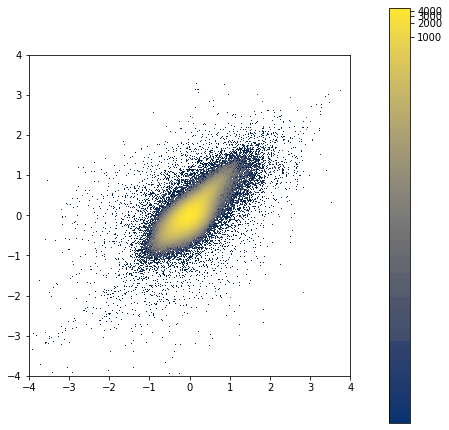

In [26]:
fig = plt.figure(figsize=(6,6),constrained_layout=True)
gs = fig.add_gridspec(1)
ax = fig.add_subplot(gs[0])
da3 = dsshow( # this is only useful for lots of data points
       ddf,
       ds.Point('X','Y'),
       norm='eq_hist',
       cmap="cividis",
    ax=ax
)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)
fig.colorbar(da3,ax=ax,shrink=0.99,pad=-0.1)

In [26]:
# bioframe is short for bioframe here ...
ctcf_df = bioframe.read_table(
    "NT-CTCF-narrowPeaks-sort-merge",
    names=["chrom","start","end"]
)
# ctcf_df = ctcf_df.sort_values(["chrom","start"])
# ctcf_df = ctcf_df[ ctcf_df["chrom"].isin(autosomal_chroms) ]
# ctcf_df = ctcf_df.reset_index(drop=True)

In [27]:
rad21_df = bioframe.read_table(
    "NT-RAD21-narrowPeaks-sort-merge",
    names=["chrom","start","end"]
)
# rad21_df = rad21_df.sort_values(["chrom","start"])
# rad21_df = rad21_df[ rad21_df["chrom"].isin(autosomal_chroms) ]
# rad21_df = rad21_df.reset_index(drop=True)

In [28]:
# bf is short for bioframe here ...
_df = pd.concat([ctcf_df,rad21_df])#.sort_values(["chrom","start"])#.reset_index(drop=True)
bioframe.merge(_df, min_dist=1000)#.to_csv("union_RAD21_CTCF.bed",header=None,index=False,sep="\t")

,chrom,start,end,n_intervals
0,chr1,10125,10508,4
1,chr1,119902,120355,1
2,chr1,122446,122790,1
3,chr1,237582,237908,2
4,chr1,556986,557295,1
...,...,...,...,...
72044,chrY,27125529,27126114,1
72045,chrY,58968444,58968914,1
72046,chrY,59001910,59002220,2
72047,chrY,59023834,59024173,1


In [29]:
# bioframe is short for bioframe here ...
ctcf_df = bioframe.read_table(
    "NT-CTCF-narrowPeaks-sort-merge",
    names=["chrom","start","end"]
)
# ctcf_df = ctcf_df.sort_values(["chrom","start"])
# ctcf_df = ctcf_df[ ctcf_df["chrom"].isin(autosomal_chroms) ]
ctcf_df = ctcf_df.reset_index(drop=True)

In [30]:
rad21_df = bioframe.read_table(
    "NT-RAD21-narrowPeaks-sort-merge",
    names=["chrom","start","end"]
)
# rad21_df = rad21_df.sort_values(["chrom","start"])
# rad21_df = rad21_df[ rad21_df["chrom"].isin(autosomal_chroms) ]
rad21_df = rad21_df.reset_index(drop=True)

In [37]:
a = rad21_df.head()

,chrom,start,end
0,chr1,10125,10442
1,chr1,805137,805533
2,chr1,839834,840961
3,chr1,875607,875826
4,chr1,877161,877453


In [60]:
rad21_df.iloc[2490:2500]

,chrom,start,end
2490,chr10,15210456,15210757
2491,chr10,15331652,15331958
2492,chr10,15412381,15412807
2493,chr10,15413261,15413512
2494,chr10,15476178,15476486
2495,chr10,15944753,15944989
2496,chr10,16819509,16819836
2497,chr10,16870176,16870529
2498,chr10,17048997,17049303
2499,chr10,17241379,17241600


In [83]:
x = pd.DataFrame({"chrom":["chr1","chr2"],"start":[100,400],"end":[110,410]})
# x.index = [0,0]
bioframe.merge(x, min_dist=5)


,chrom,start,end,n_intervals
0,chr1,100,110,1
1,chr2,400,410,1


In [82]:
x = pd.DataFrame({"chrom":["chr1","chr1","chr2","chr2"],"start":[100,200,300,400],"end":[110,210,310,410]})
# x.index = [0,1,0,1]
# x.dtypes
bioframe.merge(x, min_dist=5)


,chrom,start,end,n_intervals
0,chr1,100,110,1
1,chr1,200,210,1
2,chr2,300,310,1
3,chr2,400,410,1


In [73]:
a.dtypes

chrom    object
start     int64
end       int64
dtype: object

In [71]:
a = rad21_df.iloc[2490:2500]
b = ctcf_df.iloc[2490:2500]
pd.concat([a,b])


,chrom,start,end
2490,chr10,15210456,15210757
2491,chr10,15331652,15331958
2492,chr10,15412381,15412807
2493,chr10,15413261,15413512
2494,chr10,15476178,15476486
2495,chr10,15944753,15944989
2496,chr10,16819509,16819836
2497,chr10,16870176,16870529
2498,chr10,17048997,17049303
2499,chr10,17241379,17241600


In [58]:
a = rad21_df.iloc[2490:2500]
b = ctcf_df.iloc[2490:2500]
c = pd.concat([a,b])
bioframe.merge(c, min_dist=1000)

,chrom,start,end,n_intervals
0,chr1,15210456,15210757,1
1,chr1,15331652,15331958,1
2,chr1,15412381,15413512,2
3,chr1,15476178,15476486,1
4,chr1,15944753,15944989,1
5,chr1,16819509,16819836,1
6,chr1,16870176,16870529,1
7,chr1,17048997,17049303,1
8,chr1,17241379,17241600,1
9,chr1,212003774,212004421,1


In [59]:
a = rad21_df.iloc[2490:2500]
b = ctcf_df.iloc[2490:2500]
c = pd.concat([a,b]).reset_index(drop=True)
bioframe.merge(c, min_dist=1000)

,chrom,start,end,n_intervals
0,chr1,212003774,212004421,1
1,chr1,212056110,212056350,1
2,chr1,212118105,212118393,1
3,chr1,212185220,212185708,1
4,chr1,212208125,212208926,1
5,chr1,212236208,212236522,1
6,chr1,212458090,212458365,1
7,chr1,212464867,212465238,1
8,chr1,212489230,212489516,1
9,chr1,212541269,212541805,1


In [33]:
# bf is short for bioframe here ...
_df = pd.concat([ctcf_df,rad21_df]).reset_index(drop=True)#.sort_values(["chrom","start"]).reset_index(drop=True)
bioframe.merge(_df, min_dist=1000)#.to_csv("union_RAD21_CTCF.bed",header=None,index=False,sep="\t")

,chrom,start,end,n_intervals
0,chr1,10125,10508,2
1,chr1,237582,237908,1
2,chr1,714001,714579,1
3,chr1,804937,805691,2
4,chr1,839834,840961,2
...,...,...,...,...
36778,chrY,13636555,13636838,1
36779,chrY,58968444,58968914,1
36780,chrY,59001910,59002220,2
36781,chrY,59023834,59024173,1


In [34]:
# bf is short for bioframe here ...
_df = pd.concat([ctcf_df,rad21_df])#.reset_index(drop=True)#.sort_values(["chrom","start"]).reset_index(drop=True)
bioframe.merge(_df, min_dist=1000)#.to_csv("union_RAD21_CTCF.bed",header=None,index=False,sep="\t")

,chrom,start,end,n_intervals
0,chr1,10125,10508,4
1,chr1,119902,120355,1
2,chr1,122446,122790,1
3,chr1,237582,237908,2
4,chr1,556986,557295,1
...,...,...,...,...
72044,chrY,27125529,27126114,1
72045,chrY,58968444,58968914,1
72046,chrY,59001910,59002220,2
72047,chrY,59023834,59024173,1
